<a href="https://colab.research.google.com/github/RyutoYoda/Happiness_FirePower_-analysis/blob/main/Happiness%26FirePower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [8]:
# データの読み込み
military_filepath = 'global firepower 2022 wide.csv'
military_df = pd.read_csv(military_filepath)

happiness_filepath = '2022.csv'
happiness_df = pd.read_csv(happiness_filepath)

In [9]:
# データのマージ
merged_df_gb = pd.merge(left=military_df, right=happiness_df, left_on='country', right_on='Country', how='left')

In [10]:

# 不要な列の削除とデータのクリーニング
merged_df_gb.drop(columns=['Country', 'RANK', 'Whisker-high', 'Whisker-low', 'Dystopia (1.83) + residual'], inplace=True)
merged_df_gb['Happiness score'] = merged_df_gb['Happiness score'].str.replace(',', '.').astype(float)
for col in merged_df_gb.columns[2:]:
    if merged_df_gb[col].dtype == 'object':
        merged_df_gb[col] = merged_df_gb[col].str.replace(',', '.').astype(float)

# 欠損値を持つ行の削除
merged_df_gb.dropna(subset=['Happiness score'], inplace=True)

In [11]:

# 特徴量とターゲットの選定
X_gb = merged_df_gb.drop(columns=['country', 'country_code', 'Happiness score'])
y_gb = merged_df_gb['Happiness score']
# データの分割
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_gb, y_gb, test_size=0.2, random_state=42)


In [12]:
# 勾配ブースティングモデルの設定と訓練
model_gb = GradientBoostingRegressor(random_state=42)
model_gb.fit(X_train_gb, y_train_gb)


GradientBoostingRegressor(random_state=42)

In [13]:
# モデルの評価
y_pred_gb = model_gb.predict(X_test_gb)
mse_gb = mean_squared_error(y_test_gb, y_pred_gb)

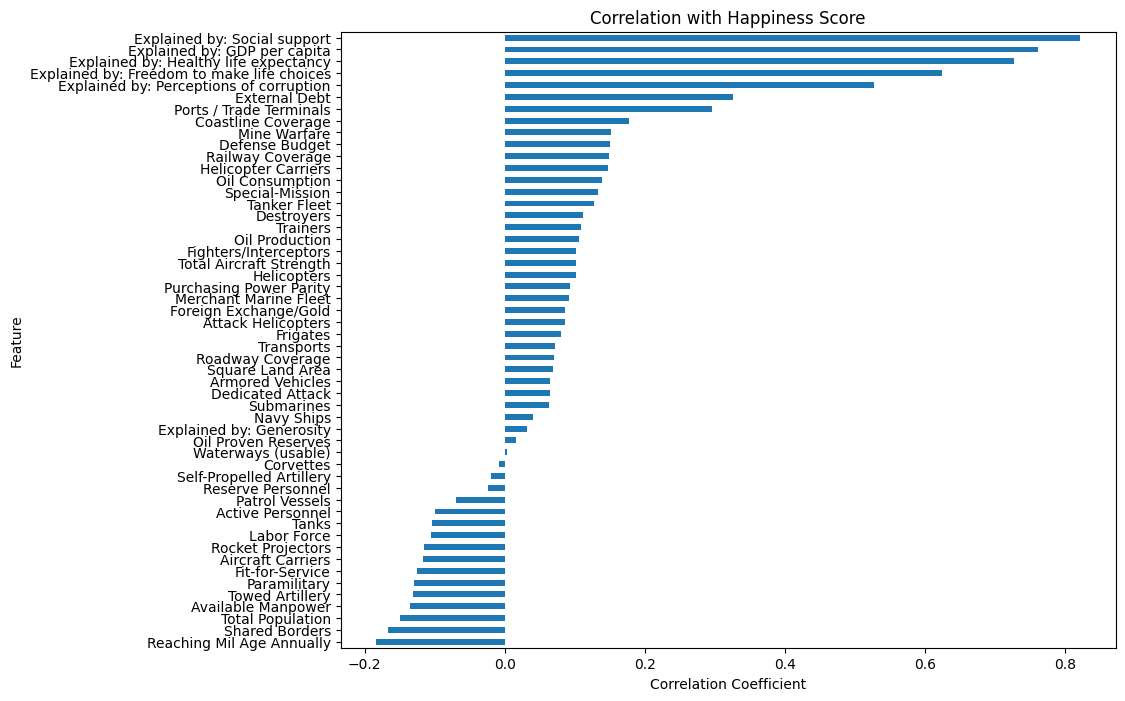

In [15]:
# 特徴量と幸福度の相関の計算と可視化
correlations = merged_df_gb.drop(columns=['country', 'country_code']).corrwith(merged_df_gb['Happiness score']).drop('Happiness score')
plt.figure(figsize=(10,8))
correlations.sort_values().plot(kind='barh')
plt.title('Correlation with Happiness Score')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.show()

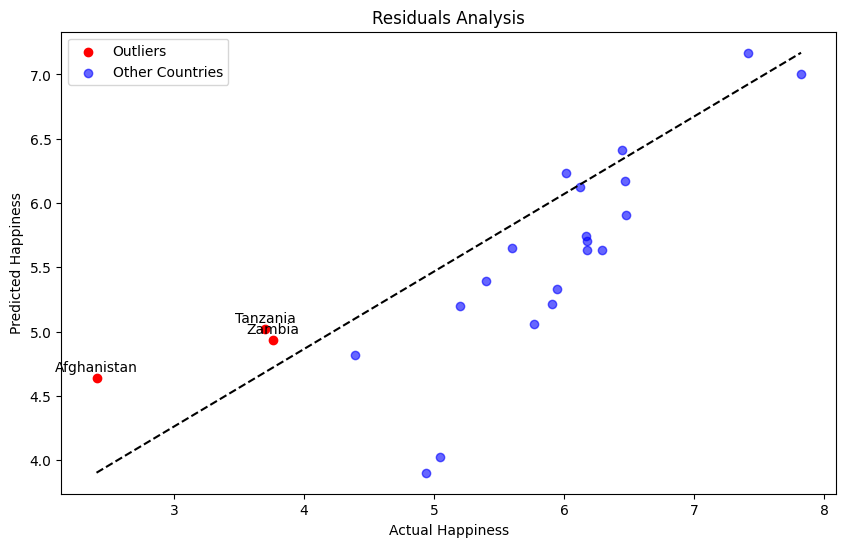

,Country,Actual Happiness,Predicted Happiness,Residuals
0,Afghanistan,2.404,4.639512,-2.235512
123,Tanzania,3.702,5.018455,-1.316455
138,Zambia,3.760,4.935782,-1.175782
53,Iraq,4.941,3.902765,1.038235
80,Mozambique,5.048,4.022661,1.025339
40,Finland,7.821,7.006230,0.814770
15,Bosnia and Herzegovina,5.768,5.058154,0.709846
97,Philippines,5.904,5.214902,0.689098
17,Brazil,6.293,5.637436,0.655564
46,Greece,5.948,5.332442,0.615558


In [25]:
# 残差の計算
residuals = y_test_gb - y_pred_gb

# 残差をテストデータセットに追加
residuals_df = X_test_gb.copy()
residuals_df['Country'] = merged_df_gb.loc[X_test_gb.index, 'country']
residuals_df['Actual Happiness'] = y_test_gb
residuals_df['Predicted Happiness'] = y_pred_gb
residuals_df['Residuals'] = residuals

# 残差の絶対値でソートし、上位の国々を表示
residuals_df = residuals_df.sort_values(by='Residuals', key=abs, ascending=False)
top_residuals_df = residuals_df.head(30)


# 外れ値の基準値を設定
threshold = residuals_df['Residuals'].abs().quantile(0.9)  # 例：残差の絶対値が上位5%以上のものを外れ値と定義

# 基準値を元に外れ値を定義
outliers_df = residuals_df[residuals_df['Residuals'].abs() >= threshold]

# 残差の散布図を描画
plt.figure(figsize=(10,6))
# 外れ値を赤でプロット
plt.scatter(outliers_df['Actual Happiness'], outliers_df['Predicted Happiness'], color='red', label='Outliers')
# それ以外の値を青でプロット
plt.scatter(residuals_df.drop(outliers_df.index)['Actual Happiness'],
            residuals_df.drop(outliers_df.index)['Predicted Happiness'],
            color='blue', alpha=0.6, label='Other Countries')

plt.title('Residuals Analysis')
plt.xlabel('Actual Happiness')
plt.ylabel('Predicted Happiness')
plt.plot([residuals_df['Actual Happiness'].min(), residuals_df['Actual Happiness'].max()],
         [residuals_df['Predicted Happiness'].min(), residuals_df['Predicted Happiness'].max()], 'k--')

# 外れ値の国名をアノテーションで追加
for idx, row in outliers_df.iterrows():
    plt.annotate(row['Country'], (row['Actual Happiness'], row['Predicted Happiness']), textcoords="offset points", xytext=(0,5), ha='center')

plt.legend()
plt.show()

# 大きな残差を持つ国々のデータも表示
top_residuals_df[['Country', 'Actual Happiness', 'Predicted Happiness', 'Residuals']]


In [44]:
# Afghanistanのデータを抽出
afghanistan_data = merged_df_gb[merged_df_gb['country'] == 'Afghanistan']
afghanistan_data

,country,country_code,Active Personnel,Aircraft Carriers,Armored Vehicles,Attack Helicopters,Available Manpower,Coastline Coverage,Corvettes,Dedicated Attack,...,Trainers,Transports,Waterways (usable),Happiness score,Explained by: GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption
0,Afghanistan,AFG,0,0,530,0,14611901,0,0,0,...,0,0,1200,2.404,0.758,0.0,0.289,0.0,0.089,0.005


In [45]:
Finland_data = merged_df_gb[merged_df_gb['country'] == 'Finland']
Finland_data

,country,country_code,Active Personnel,Aircraft Carriers,Armored Vehicles,Attack Helicopters,Available Manpower,Coastline Coverage,Corvettes,Dedicated Attack,...,Trainers,Transports,Waterways (usable),Happiness score,Explained by: GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption
40,Finland,FIN,23000,0,2090,0,2290851,1250,0,0,...,105,11,7842,7.821,1.892,1.258,0.775,0.736,0.109,0.534


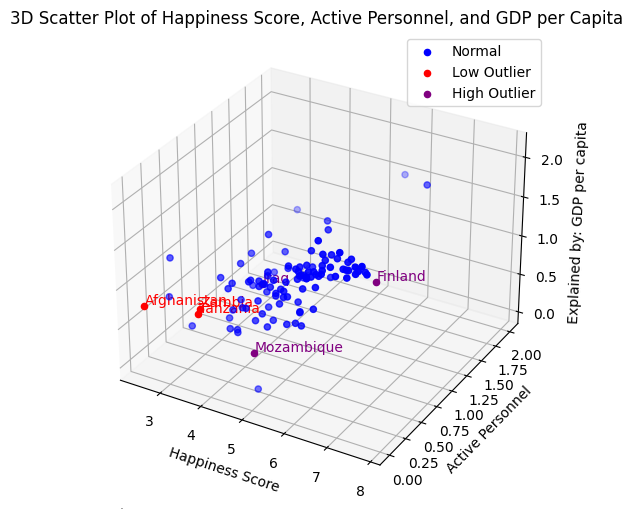

In [66]:
# 三次元プロットを作成します。
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# 外れ値の国のインデックスを取得します。
outliers_index = merged_df_gb[merged_df_gb['country'].isin(outliers)].index

# 外れ値でない国を青でプロットします。
ax.scatter(x.drop(outliers_index), y.drop(outliers_index), z.drop(outliers_index), c='b', label='Normal')

# 外れ値の国名を赤または紫でプロットします。
for idx in outliers_index:
    color = 'purple' if residuals.loc[idx, 'Residuals'] > 0 else 'red'
    label = 'High Outlier' if color == 'purple' else 'Low Outlier'
    ax.scatter(x.loc[idx], y.loc[idx], z.loc[idx], c=color, label=label)

    # ラベルが重ならないようにオフセットを加えます。
    offset_x = 0.02
    offset_y = 0.02
    offset_z = 0.02
    ax.text(x.loc[idx] + offset_x, y.loc[idx] + offset_y, z.loc[idx] + offset_z, merged_df_gb.loc[idx, 'country'], color=color)

# 重複する凡例ラベルを削除します。
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_xlabel('Happiness Score')
ax.set_ylabel('Active Personnel')
ax.set_zlabel('Explained by: GDP per capita')

plt.title('3D Scatter Plot of Happiness Score, Active Personnel, and GDP per Capita')
plt.show()


In [41]:
# 外れ値となった国のリストを出力する
print(outliers)

['Afghanistan', 'Finland', 'Iraq', 'Mozambique', 'Tanzania', 'Zambia']


In [42]:
# 幸福度スコアでデータフレームを降順にソートする
happiness_ranking = merged_df_gb[['country', 'Happiness score']].sort_values(by='Happiness score', ascending=False)

# インデックスをリセットする（ランキングを表示するため）
happiness_ranking.reset_index(drop=True, inplace=True)

# ランキングを表示する
print(happiness_ranking)


          country  Happiness score
0         Finland            7.821
1         Denmark            7.636
2     Switzerland            7.512
3     Netherlands            7.415
4          Sweden            7.384
..            ...              ...
106      Tanzania            3.702
107  Sierra Leone            3.574
108      Zimbabwe            2.995
109       Lebanon            2.955
110   Afghanistan            2.404

[111 rows x 2 columns]
